##  Case Type: B2B Demand forecasting of a particular product
##  Use and context of the data
The dataset contains historical product demand for a manufacturing company with footprints globally. The company provides thousands of products within dozens of product categories. There are four central warehouses to ship products within the region it is responsible for. Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. If forecasts for each product in different central with reasonable accuracy for the monthly demand for month after next can be achieved, it would be beneficial to the company in multiple ways.

## Import modules and data

In [24]:
import math
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
dataframe = pd.read_csv("Historical Product Demand.csv")
dataframe.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


# Count of Products by grouping

In [25]:
dataframe_grouped = dataframe.groupby(['Product_Code']).size().reset_index(name='counts').sort_values(['counts'],ascending=False)
dataframe_grouped.head()

,Product_Code,counts
1348,Product_1359,16936
1284,Product_1295,10575
1367,Product_1378,9770
619,Product_0620,9428
1275,Product_1286,8888


# Select a product to work on this project
We will be working on demand forecasting of product 1359 as it has the highest count. There is no particular way of choosing a product and any of the above products can be worked upon for its demand forecasting

## We do not need the details of 'Warehouse', 'Product Code' and 'Product Category' for demand forecasting. All we need is the demand and time(date)

In [26]:
dataframe_for_product1359 = dataframe.loc[dataframe['Product_Code'] == 'Product_1359'].sort_values(['Date'],ascending=False)
dataframe_for_product1359=dataframe_for_product1359.drop(columns=['Warehouse','Product_Code','Product_Category'])
dataframe_for_product1359.head()

,Date,Order_Demand
921328,2017/1/6,100000
863636,2016/9/9,9000
893829,2016/9/9,40000
1013066,2016/9/9,2000
863593,2016/9/9,1000


## Creating the major axis-that is Time. All the data will now be indexed in terms of time.

In [27]:
dataframe_for_product1359.index=pd.to_datetime(dataframe_for_product1359.Date,format='%Y/%m/%d') 
dataframe_for_product1359.drop(columns=['Date'],inplace=True)
dataframe_for_product1359.head(2)

,Order_Demand
Date,
2017-01-06,100000
2016-09-09,9000


# Formatting

In [28]:
dataframe_for_product1359['Order_Demand'] = dataframe_for_product1359['Order_Demand'].astype(str)
dataframe_for_product1359['Order_Demand'] = dataframe_for_product1359['Order_Demand'].map(lambda x: x.lstrip('(').rstrip(')'))
dataframe_for_product1359['Order_Demand'] = dataframe_for_product1359['Order_Demand'].astype(int)
dataframe_for_product1359.head()

,Order_Demand
Date,
2017-01-06,100000
2016-09-09,9000
2016-09-09,40000
2016-09-09,2000
2016-09-09,1000


# Determining Monthly Demand
Get the demand in terms of January, February.....December

In [54]:
dataframe_for_product1359_Monthly= dataframe_for_product1359.resample('M').sum()
dataframe_for_product1359_Monthly.head()

,Order_Demand
Date,
2012-01-31,8911000
2012-02-29,8131000
2012-03-31,7775000
2012-04-30,8960000
2012-05-31,8475000


## Note that the sharp dip in 2017 is due to the data being incomplete in 2017

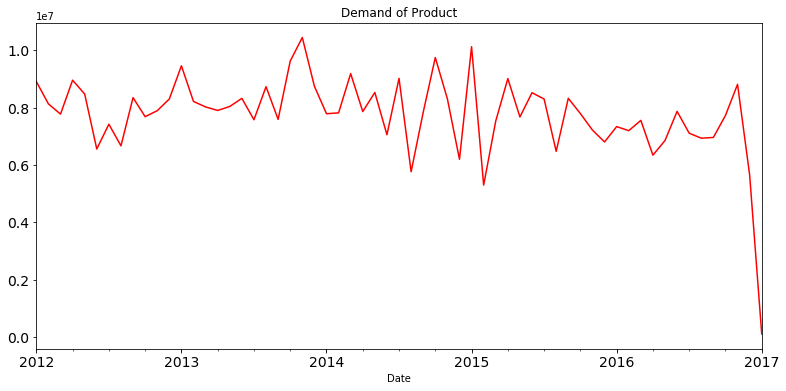

In [30]:
dataframe_for_product1359_Monthly.Order_Demand.plot(figsize=(13,6), title= 'Demand of Product', fontsize=14,color="Red")
plt.show()

# Create Train and Test Data
Last 10 months make up the test data

In [31]:
Demand_for_1359_Train = dataframe_for_product1359_Monthly[:'2016-03-31']
Demand_for_1359Test = dataframe_for_product1359_Monthly['2016-04-30':'2016-12-31']

## Demand for product 1359

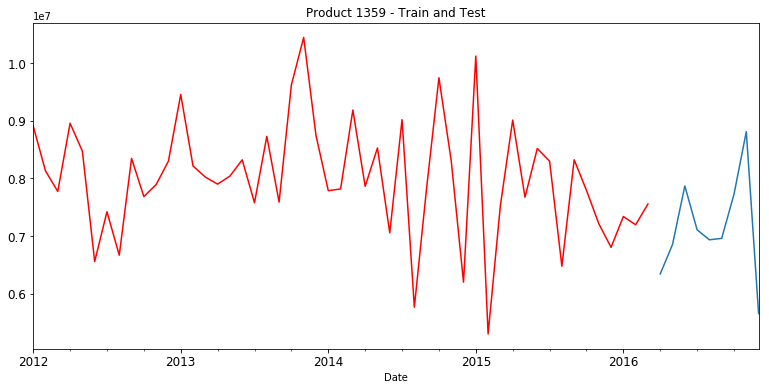

In [56]:
Demand_for_1359_Train.Order_Demand.plot(figsize=(13,6), title= 'Product 1359 - Train and Test', fontsize=12,color="Red")
Demand_for_1359Test.Order_Demand.plot(figsize=(13,6), title= 'Product 1359 - Train and Test', fontsize=12)
plt.show()


# Simple Smoothing


In [49]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = Demand_for_1359Test.copy()
fit2 = SimpleExpSmoothing(np.asarray(Demand_for_1359_Train['Order_Demand'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(Demand_for_1359Test))


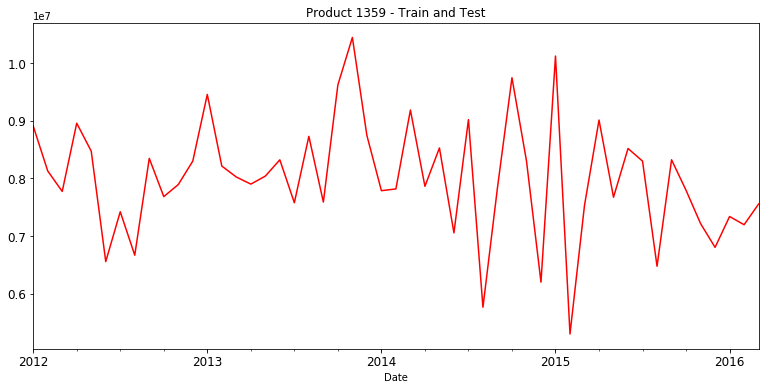

In [50]:
Demand_for_1359_Train.Order_Demand.plot(figsize=(13,6), title= 'Product 1359 - Train and Test', fontsize=12,color="Red")
plt.plot(Demand_for_1359_Train['Order_Demand'], label='Train',color="Red")
plt.show()

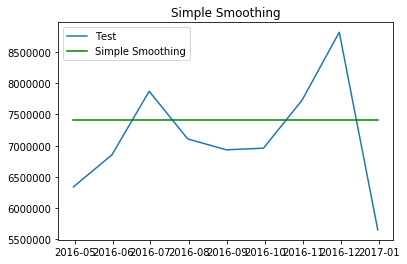

In [57]:
plt.plot(Demand_for_1359Test['Order_Demand'], label='Test')
plt.plot(y_hat_avg['SES'], label='Simple Smoothing',color="Green")
plt.title("Simple Smoothing")
plt.legend(loc='best')
plt.show()

# Root mean square error calculation

In [34]:
smooth_rms = math.sqrt(mean_squared_error(Demand_for_1359Test.Order_Demand, y_hat_avg.SES))
print(smooth_rms)

905476.4628886498


# Exponential Smoothing
Exponential smoothing uses the weighted average of previous observations where more weight is given to the most recent observations and the weight decreases as observations get older.

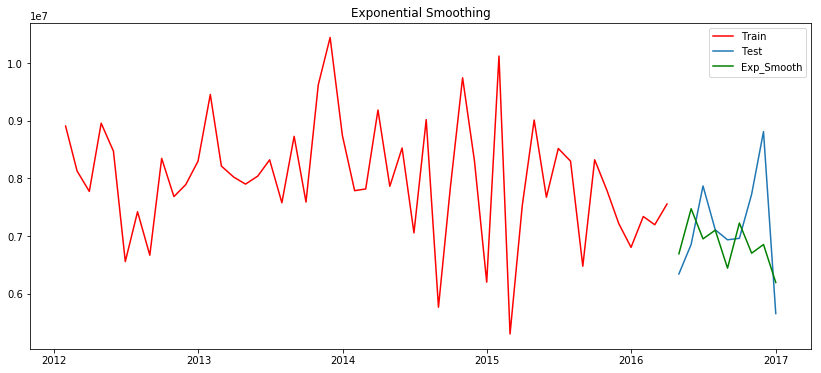

In [38]:
exp_hat_avg = Demand_for_1359Test.copy()
fit1 = ExponentialSmoothing(np.asarray(Demand_for_1359_Train['Order_Demand']) ,seasonal_periods=4 ,trend='additive', seasonal='additive',).fit()
exp_hat_avg['Exp_Smooth'] = fit1.forecast(len(Demand_for_1359Test))
plt.figure(figsize=(14,6))
plt.plot( Demand_for_1359_Train['Order_Demand'], label='Train',color="Red")
plt.plot(Demand_for_1359Test['Order_Demand'], label='Test')
plt.plot(exp_hat_avg['Exp_Smooth'], label='Exp_Smooth',color="Green")
plt.legend(loc='best')
plt.title("Exponential Smoothing");
plt.show()

## Root mean square error calculation

In [58]:
exp_rms = math.sqrt(mean_squared_error(Demand_for_1359Test.Order_Demand, exp_hat_avg.Exp_Smooth))
print(exp_rms)

872760.1292784497
